In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1CL6sW-6ihiyRKnH81g1LKxgUWBEk7cv-'})
download.GetContentFile('OCT2019.zip')

In [ ]:
import zipfile
import io
data = zipfile.ZipFile('OCT2019.zip', 'r')
data.extractall()

In [ ]:
train_dir='OCT2019/Training'
test_dir='OCT2019/Testing'
validate_dir='OCT2019/Validation'

In [ ]:
##################################################### data preprocessing ###################################
from keras.preprocessing.image import ImageDataGenerator
image_size=256
batch_size=32
data_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 height_shift_range=0.2,
                                 width_shift_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 zoom_range=0.2,
                                fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_directory(train_dir,
                        target_size=(image_size, image_size),batch_size=batch_size,
                        class_mode='categorical')

valid_generator = data_generator.flow_from_directory(validate_dir,
                        target_size=(image_size, image_size),batch_size=batch_size,
                        class_mode='categorical')


#----------------------------------------------model------------------------------------------------------
import keras 
from keras.models import *
from keras.layers import *
from keras.preprocessing import image 
import PIL
from keras import layers,optimizers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.applications import DenseNet121

model = models.Sequential()

model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(256, 256, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(4,activation='softmax')(x)
model=Model(inputs=model_d.input,outputs=preds)

model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])



Found 6000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history=model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples/train_generator.batch_size,
                    verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
187/187 [==============================] - 155s 739ms/step - loss: 2.1794 - accuracy: 0.3059 - val_loss: 1.2152 - val_accuracy: 0.5050
Epoch 2/100
187/187 [==============================] - 135s 718ms/step - loss: 0.9901 - accuracy: 0.6539 - val_loss: 0.6947 - val_accuracy: 0.7620
Epoch 3/100
187/187 [==============================] - 135s 719ms/step - loss: 0.5130 - accuracy: 0.8201 - val_loss: 0.6797 - val_accuracy: 0.7960
Epoch 4/100
187/187 [==============================] - 135s 719ms/step - loss: 0.3942 - accuracy: 0.8707 - val_loss: 0.5553 - val_accuracy: 0.8200
Epoch 5/100
187/187 [==============================] - 135s 720ms/step - loss: 0.3308 - accuracy: 0.8909 - val_loss: 0.5000 - val_accuracy: 0.8490
Epoch 6/100
187/187 [==============================] - 135s 721ms/step - loss: 0.2776 - accuracy: 0.9089 - val_loss: 0.6261 - val_accuracy: 0.8270
Epoch 7/100
187/187 [==============================] - 135s 721ms/step - loss: 0.2309 - accuracy: 0.9291 - val_loss: 0

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size=32,
    class_mode='categorical')
    
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 1000 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9900000095367432
test loss: 0.04768458753824234


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

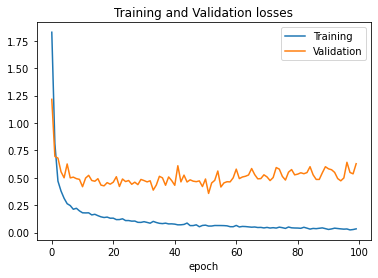

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

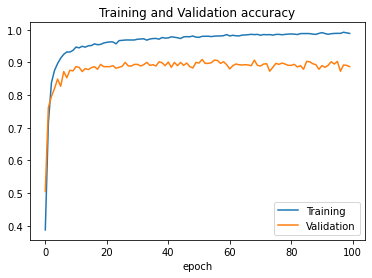

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')